# NoteBook Setup




> The cell below are will install all the necessary python packages required for the notebook to function

In [9]:
#This cell denotes the required packages for the notebook to work
%pip install mysql-connector-python numpy pandas seaborn matplotlib plotly sqlalchemy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
#Library import

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sqlalchemy

# Database Connection


In [ ]:
#This cell creates a link to to database and extract all the tables.
import streamlit as st

# Establish the database connection using a SQLAlchemy engine.
db_connection_str = st.secrets.get("DB_CONNECTION_STRING")
if not db_connection_str:
    raise ValueError("No DB_CONNECTION_STRING found in environment or Streamlit secrets.")
engine = sqlalchemy.create_engine(db_connection_str)

# Get a list of all table names from the database and filter for 'long' tables.
inspector = sqlalchemy.inspect(engine)
all_tables = inspector.get_table_names()
long_tables = [table for table in all_tables if table.endswith('long')]
wide_tables = [table for table in all_tables if table.endswith('wide')]

#get first elemtn of wide_tables to make into pd.dataframe
df_wide = pd.read_sql(f"SELECT * FROM {wide_tables[0]}", engine)
df_long = pd.read_sql(f"SELECT * FROM {long_tables[0]}", engine)

#iterate through long_tables and store it into a dict df_long_dict
df_long_dict = {}
for table in long_tables:
    df_long_dict[table] = pd.read_sql(f"SELECT * FROM {table}", engine)

#iterate through wide_tables and store it into a dict df_wide_dict
df_wide_dict = {}
for table in wide_tables:
    df_wide_dict[table] = pd.read_sql(f"SELECT * FROM {table}", engine)


In [26]:
#loop through df_long_dict and change all year from int type to to_datetime(df['year'], format="%Y")
for key, value in df_long_dict.items():
    df_long_dict[key]['year'] = pd.to_datetime(df_long_dict[key]['year'], format="%Y")

C:\Users\ZJun\AppData\Local\Temp\ipykernel_41748\3159644827.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#FirstDraft


## Module 2 ( Data Cleaning )

### Additional Data (Plot out employed workforce by reserve calculation from 2 tables)

#### df_long_dict["employed_by occupation_long"]

In [13]:
# Get total unemployed_count per occupation (sum male + female)
df_unemp = df_long_dict['unemployed_by_previous_occupation_sex_long']
unemp_sum = df_unemp.groupby(['year', 'occupation'])['unemployed_count'].sum().reset_index()

# Get unemployed_rate per occupation
df_rate = df_long_dict["unemployment_rate_by_occupation_long"][['year', 'occupation', 'unemployed_rate']]

# Merge on year and occupation
merged = pd.merge(unemp_sum, df_rate, on=['year', 'occupation'], how='inner')

# Convert unemployed_rate from percent to proportion
merged['unemployed_rate_prop'] = merged['unemployed_rate'] / 100

# Calculate employed_count
merged['employed_count'] = merged['unemployed_count'] * (1 / merged['unemployed_rate_prop'] - 1)

# Final DataFrame with employed_count and occupation
result_df = merged[['year', 'occupation', 'employed_count']]

df_long_dict["employed_by occupation_long"] = result_df

#### df_long_dict["employed_by occupation_sex_long"]

In [14]:
# Get unemployed_count per year, occupation, gender
df_unemp = df_long_dict['unemployed_by_previous_occupation_sex_long']
unemp_sum = df_unemp.groupby(['year', 'occupation', 'gender'])['unemployed_count'].sum().reset_index()

# Get unemployed_rate per year, occupation (rate is for total, not by gender)
df_rate = df_long_dict["unemployment_rate_by_occupation_long"][['year', 'occupation', 'unemployed_rate']]

# Merge on year and occupation (rate will be duplicated for both genders)
merged = pd.merge(unemp_sum, df_rate, on=['year', 'occupation'], how='inner')

# Convert unemployed_rate from percent to proportion
merged['unemployed_rate_prop'] = merged['unemployed_rate'] / 100

# Calculate employed_count per gender
merged['employed_count'] = merged['unemployed_count'] * (1 / merged['unemployed_rate_prop'] - 1)

# Final DataFrame with employed_count, occupation, gender
result_df = merged[['year', 'occupation', 'gender', 'employed_count']]

df_long_dict["employed_by occupation_sex_long"] = result_df

df_long_dict["employed_by occupation_sex_long"]

,year,occupation,gender,employed_count
0,2014-01-01,Associate Professionals & Technicians,Female,200.051613
1,2014-01-01,Associate Professionals & Technicians,Male,196.925806
2,2014-01-01,"Cleaners, Labourers & Related Workers",Female,75.669767
3,2014-01-01,"Cleaners, Labourers & Related Workers",Male,91.248837
4,2014-01-01,Clerical Support Workers,Female,184.377551
...,...,...,...,...
171,2024-01-01,Plant & Machine Operators & Assemblers,Male,111.714815
172,2024-01-01,Professionals,Female,284.604348
173,2024-01-01,Professionals,Male,335.578261
174,2024-01-01,Service & Sales Workers,Female,120.500000


### Data Checking

> The cell below will do a inital check on the datas imported into the sql database. It loops though all the tables and print out the necessary information.

In [15]:
#Explore Data
import pandas as pd

# Loop through the filtered list of tables.
for table_name, df in df_long_dict.items():
    print(f"--- Processing table: '{table_name}' ---")

    # Show the .info() for the DataFrame.
    print("DataFrame Info:")
    df.info()

    # Showf"\nDescriptive Statistics of '{table_name}':")
    print(f"\nDescriptive Statistics of '{table_name}':")
    print(df.describe())

    # Show the .head() for the DataFrame.
    print(f"\nFirst 5 rows of '{table_name}':")
    print(df.head())

    # Show the categorical values for the DataFrame.
    print(f"\nValue Counts for Categorical Columns in '{table_name}':")
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts(dropna=False))

    # Show Duplicates
    print(f"\nDuplicates in '{table_name}':")
    duplicates_all = df[df.duplicated(keep=False)]
    print(duplicates_all)

    # Print a separator for clarity.
    print("\n" + "="*80 + "\n")

--- Processing table: 'long_term_unemployed_pmets_by_age_long' ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              88 non-null     datetime64[ns]
 1   pmets_status      88 non-null     object        
 2   age_group         88 non-null     object        
 3   unemployed_count  88 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.9+ KB

Descriptive Statistics of 'long_term_unemployed_pmets_by_age_long':
                                year  unemployed_count
count                             88         88.000000
mean   2019-01-01 02:10:54.545454592         10.250000
min              2014-01-01 00:00:00          4.200000
25%              2016-01-01 00:00:00          7.475000
50%              2019-01-01 00:00:00          8.900000
75%              2022

### Find Outliers

Next we loop through the tables again and look for outliers through histogram and boxplot. Extreme data are annotated and displayed.

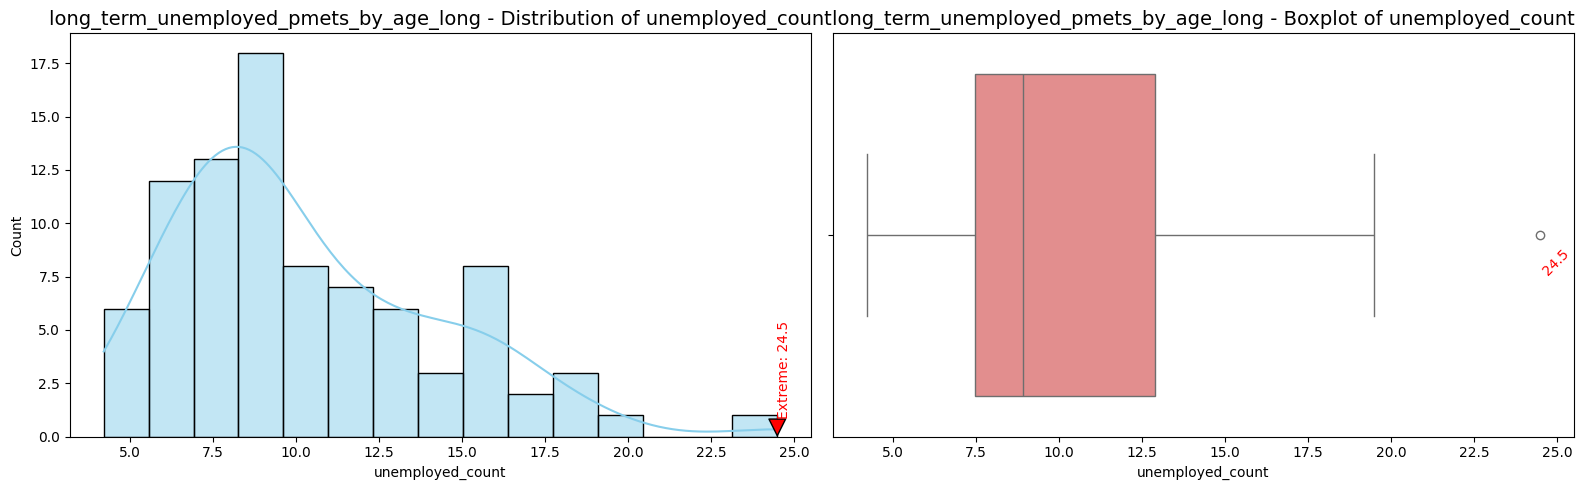

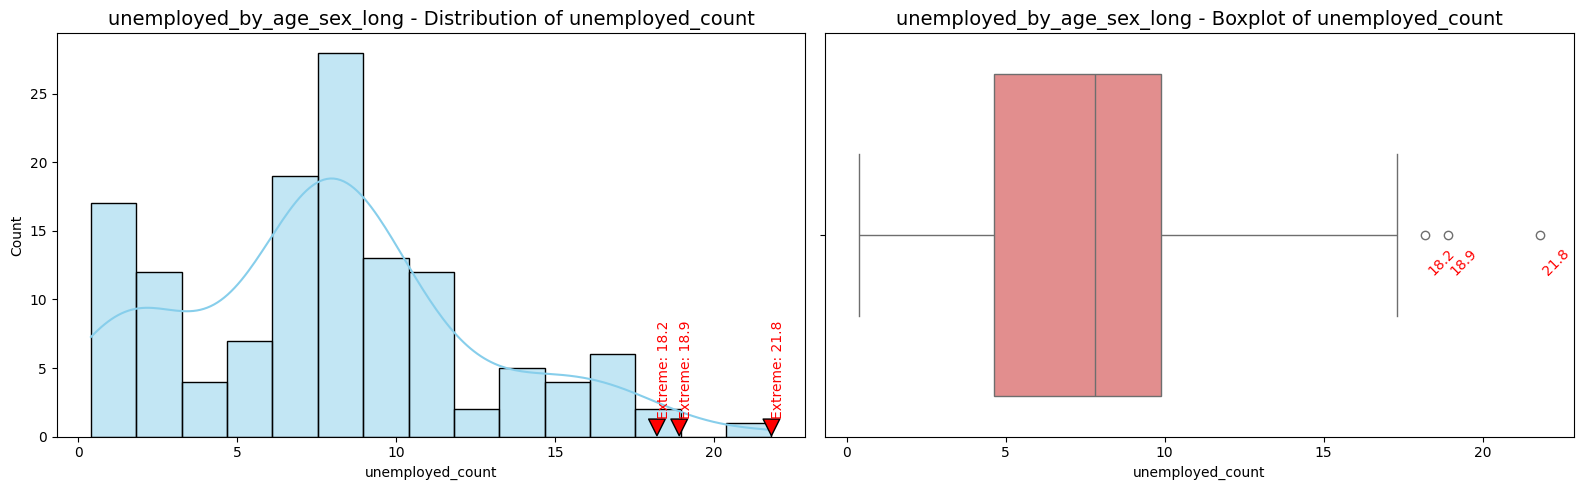

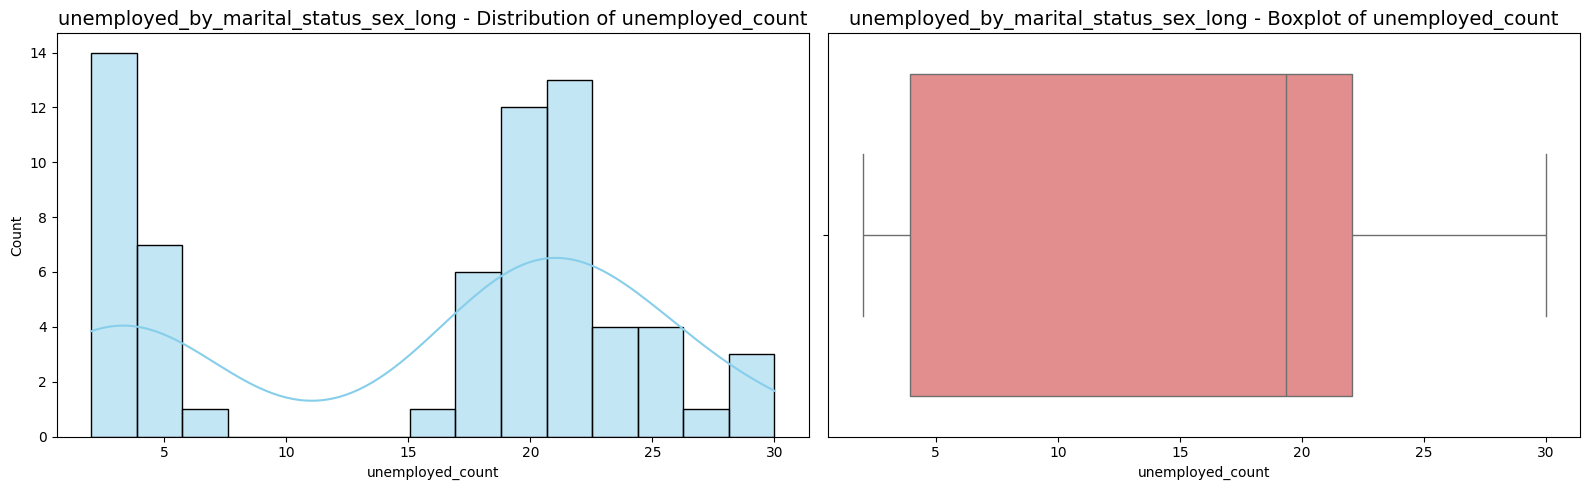

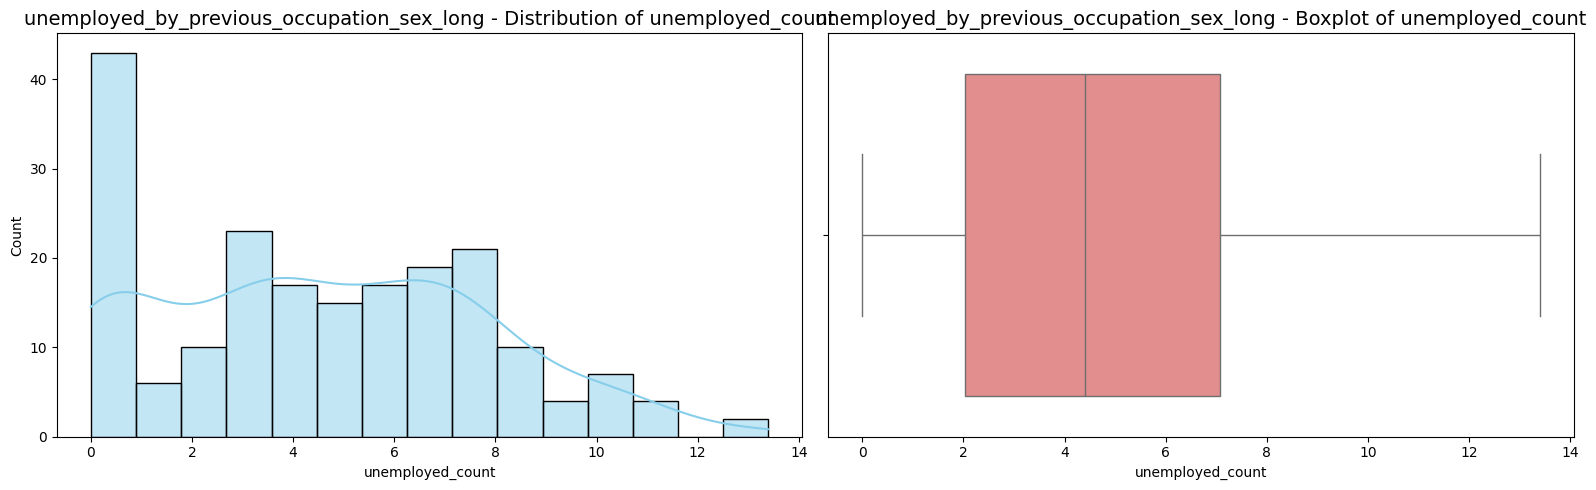

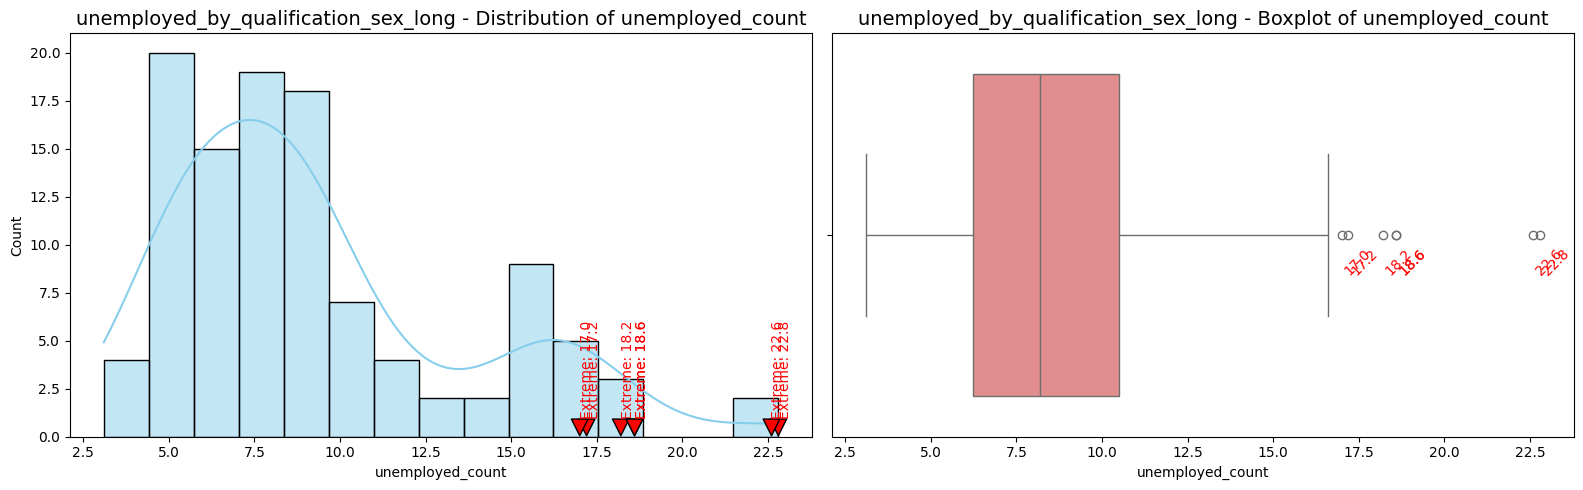

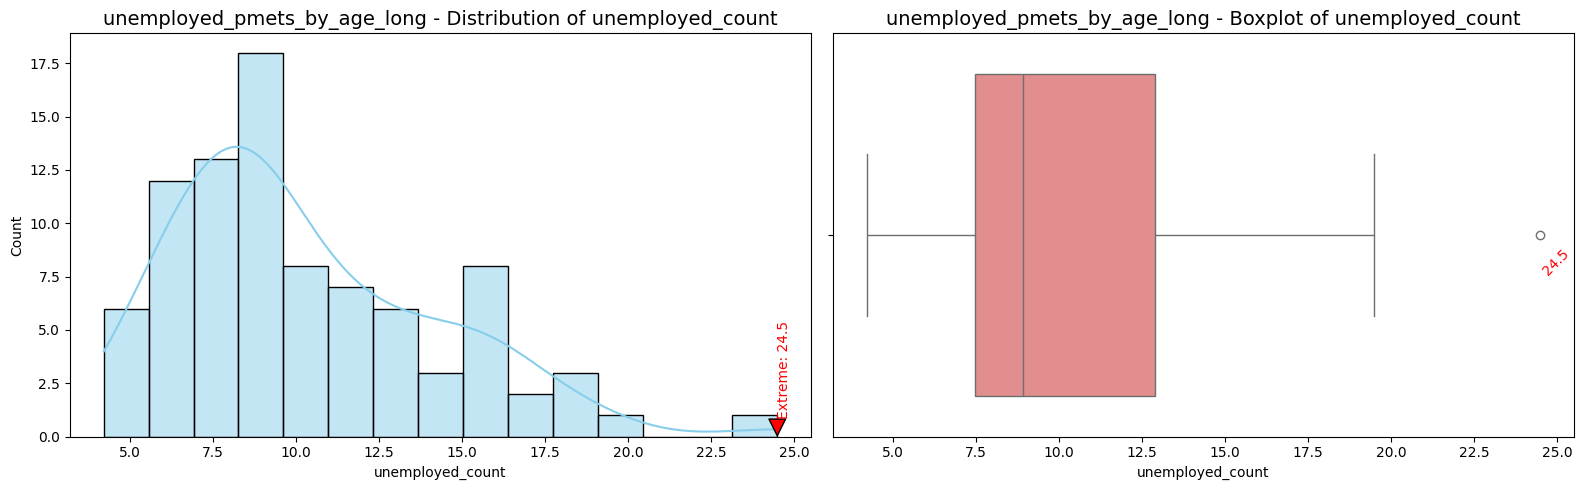

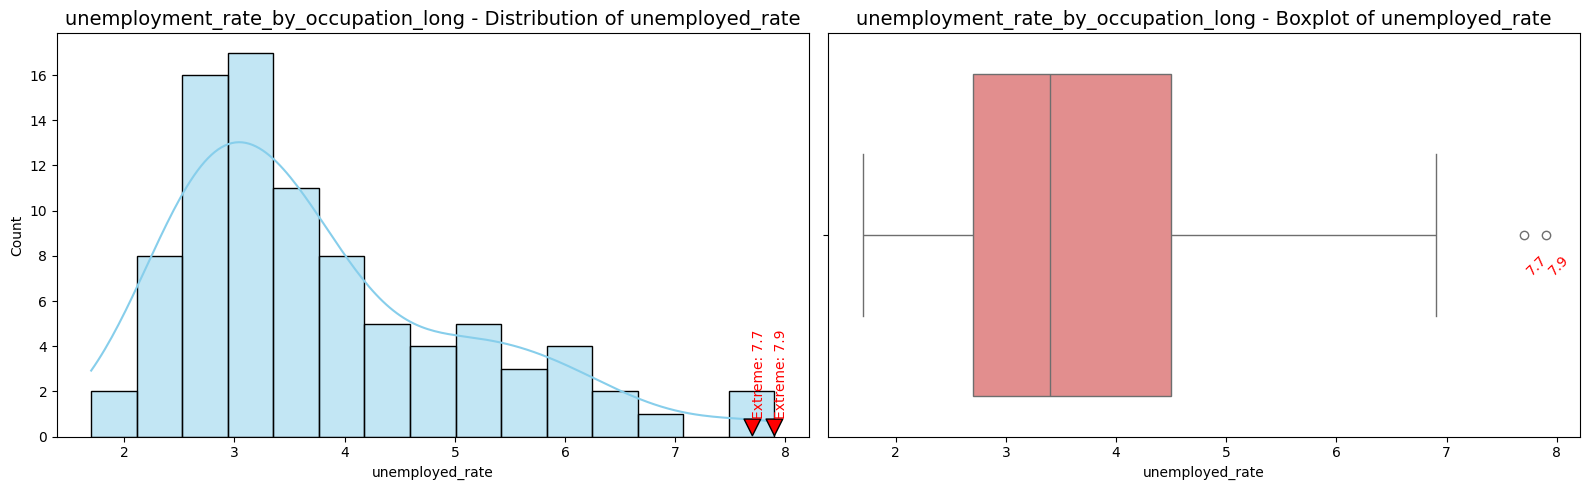

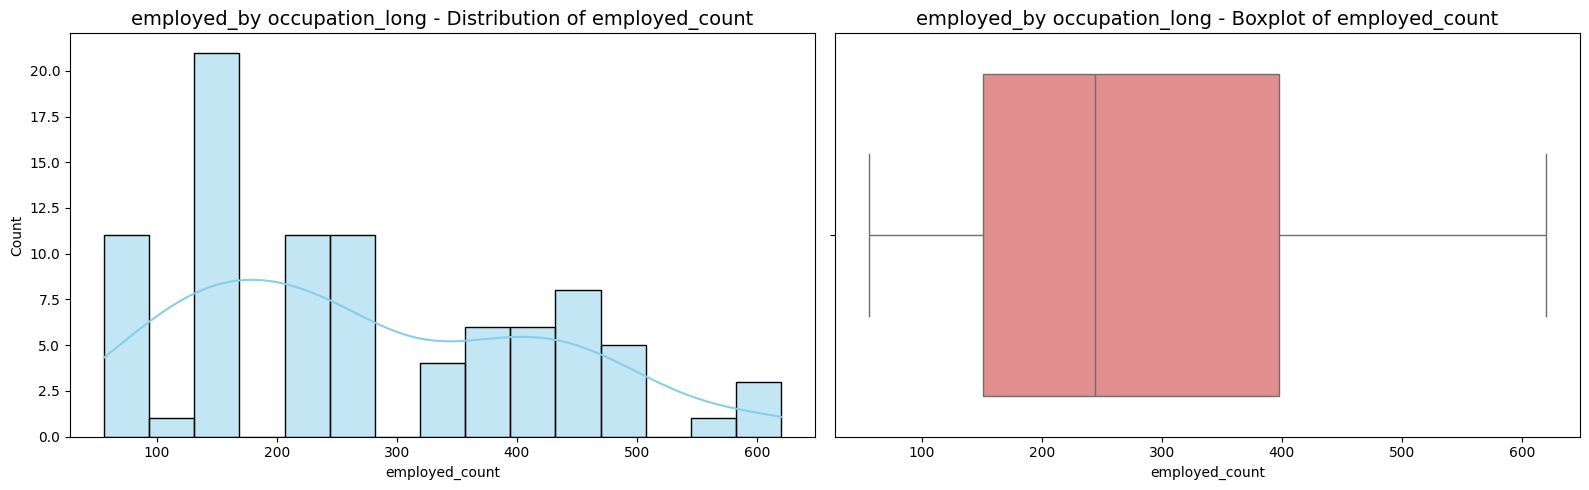

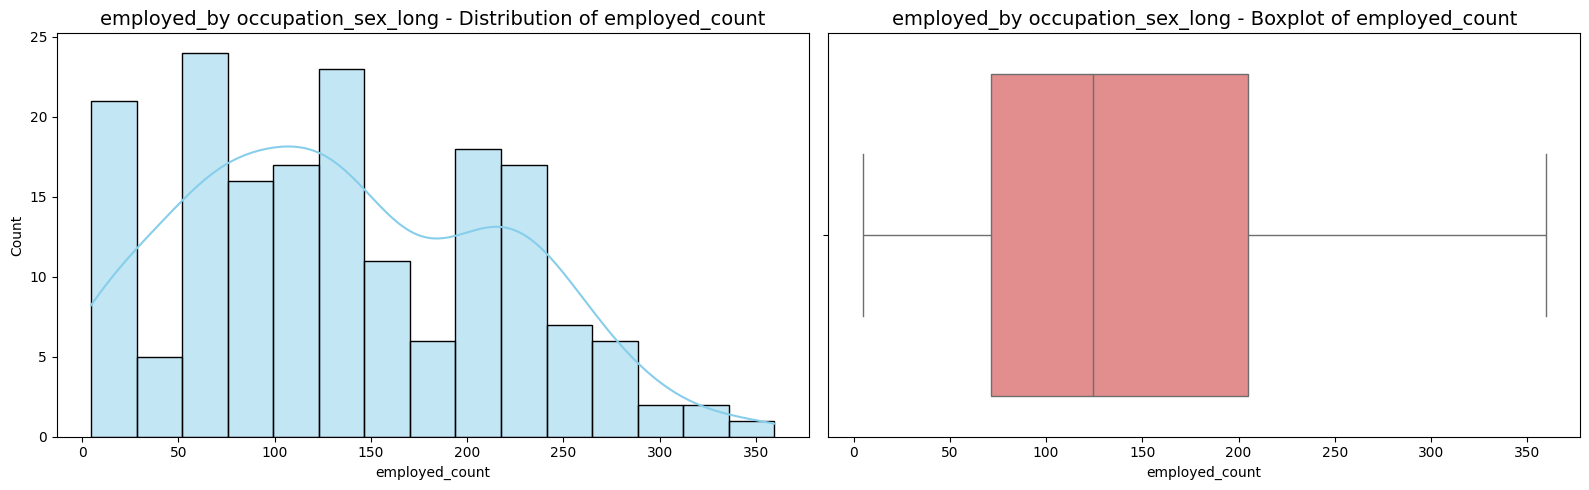

In [16]:
for table_name, df in df_long_dict.items():
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numeric_cols:
        # Create a figure with 1 row and 2 columns (side by side plots)
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # Left plot: Histogram
        sns.histplot(df[col], bins=15, kde=True, color='skyblue', ax=axes[0])
        axes[0].set_title(f'{table_name} - Distribution of {col}', fontsize=14)
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')
        
        # Right plot: Boxplot
        sns.boxplot(x=df[col], color='lightcoral', ax=axes[1])
        axes[1].set_title(f'{table_name} - Boxplot of {col}', fontsize=14)
        
        # Calculate outliers
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5*iqr
        lower = q1 - 1.5*iqr
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        
        # Annotate outliers in histogram
        for val in outliers:
            axes[0].annotate(f'Extreme: {val}', 
                            xy=(val, 0), 
                            xytext=(val, axes[0].get_ylim()[1]*0.05),
                            arrowprops=dict(facecolor='red', shrink=0.05), 
                            rotation=90, 
                            color='red')
        
        # Annotate outliers in boxplot
        for val in outliers:
            axes[1].annotate(f'{val}', 
                            xy=(val, 0), 
                            xytext=(val, 0.1),
                            rotation=45, 
                            color='red')
        
        plt.tight_layout()
        plt.show()

## Module 3 ( Data Visualizing )

### Main Research Question:
How have different industries and occupations contributed to the unemployment rate in Singapore?


**Hypothesis**

Lower-skilled occupations such as service, sales, clerical support, and manual labour consistently have higher unemployment rates compared to higher-skilled occupations such as managers and professionals in Singapore.

**Predictions**

Lower-skilled occupations will continue to have higher unemployment rates.
Examples of predictive questions:
How are unemployment rates in lower-skilled occupations likely to trend compared to higher-skilled occupations?
Which occupations are at greater risk of higher unemployment rates in the coming years?
What is the projected unemployment rate for lower-skilled occupations relative to other groups?




 ### Unemployment rates in Singapore by occupation group (2014–2024).


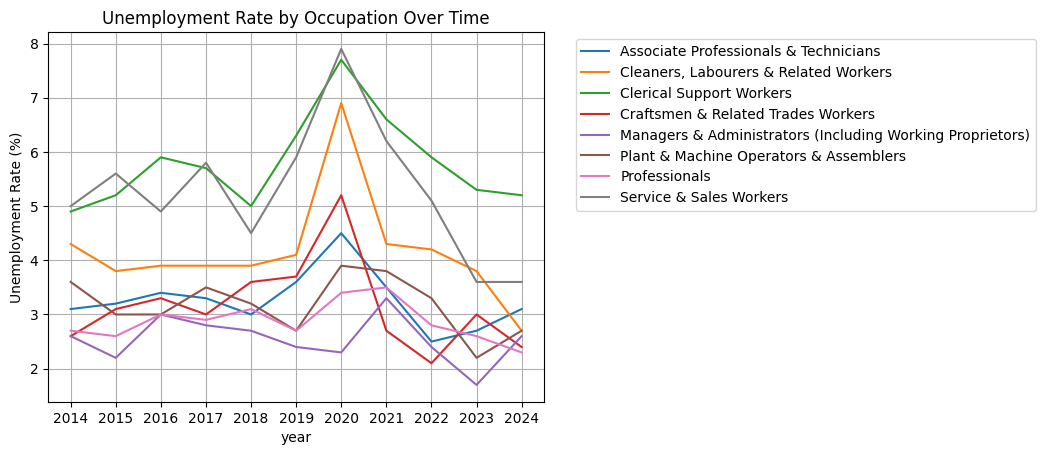

In [ ]:
# Unemployment Rate by Occupation Over Time - Trend Analysis
df = df_long_dict["unemployment_rate_by_occupation_long"]

sns.lineplot(
  data=df,
  x="year",
  y="unemployed_rate",
  hue="occupation"
)
plt.title("Unemployment Rate by Occupation Over Time")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

 Clerical support, service, and manual labor occupations show persistently higher unemployment compared to professionals and managers, with the sharpest spike during the 2020 downturn.

### Unemployment rates in Singapore by skill level (2014–2024).

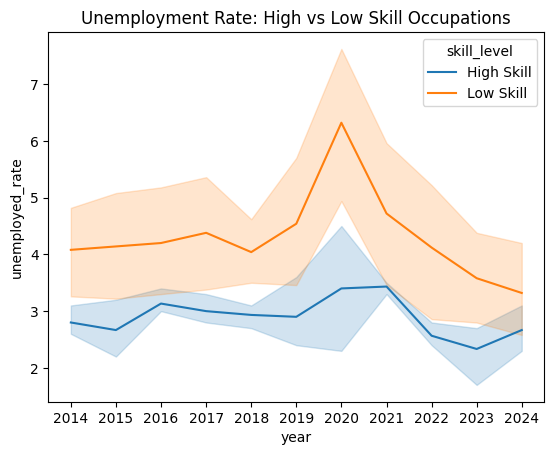

In [17]:
df = df_long_dict["unemployment_rate_by_occupation_long"]

high_skill = ["Professionals", "Managers & Administrators (Including Working Proprietors)","Associate Professionals & Technicians"]
low_skill = ["Cleaners, Labourers & Related Workers", "Service & Sales Workers","Clerical Support Workers", "Craftsmen & Related Trades Workers","Plant & Machine Operators & Assemblers"]

df["skill_level"] = df["occupation"].apply(
    lambda x: "High Skill" if x in high_skill else ("Low Skill" if x in low_skill else "Other")
)

sns.lineplot(
    data=df,
    x="year",
    y="unemployed_rate",
    hue="skill_level"
)
plt.title("Unemployment Rate: High vs Low Skill Occupations")
plt.show()

 > Lower-skilled occupations consistently face higher unemployment than higher-skilled occupations, with a sharper spike during the 2020 downturn and a slower recovery thereafter.

### Share of unemployment in Singapore by occupation (2014–2024).

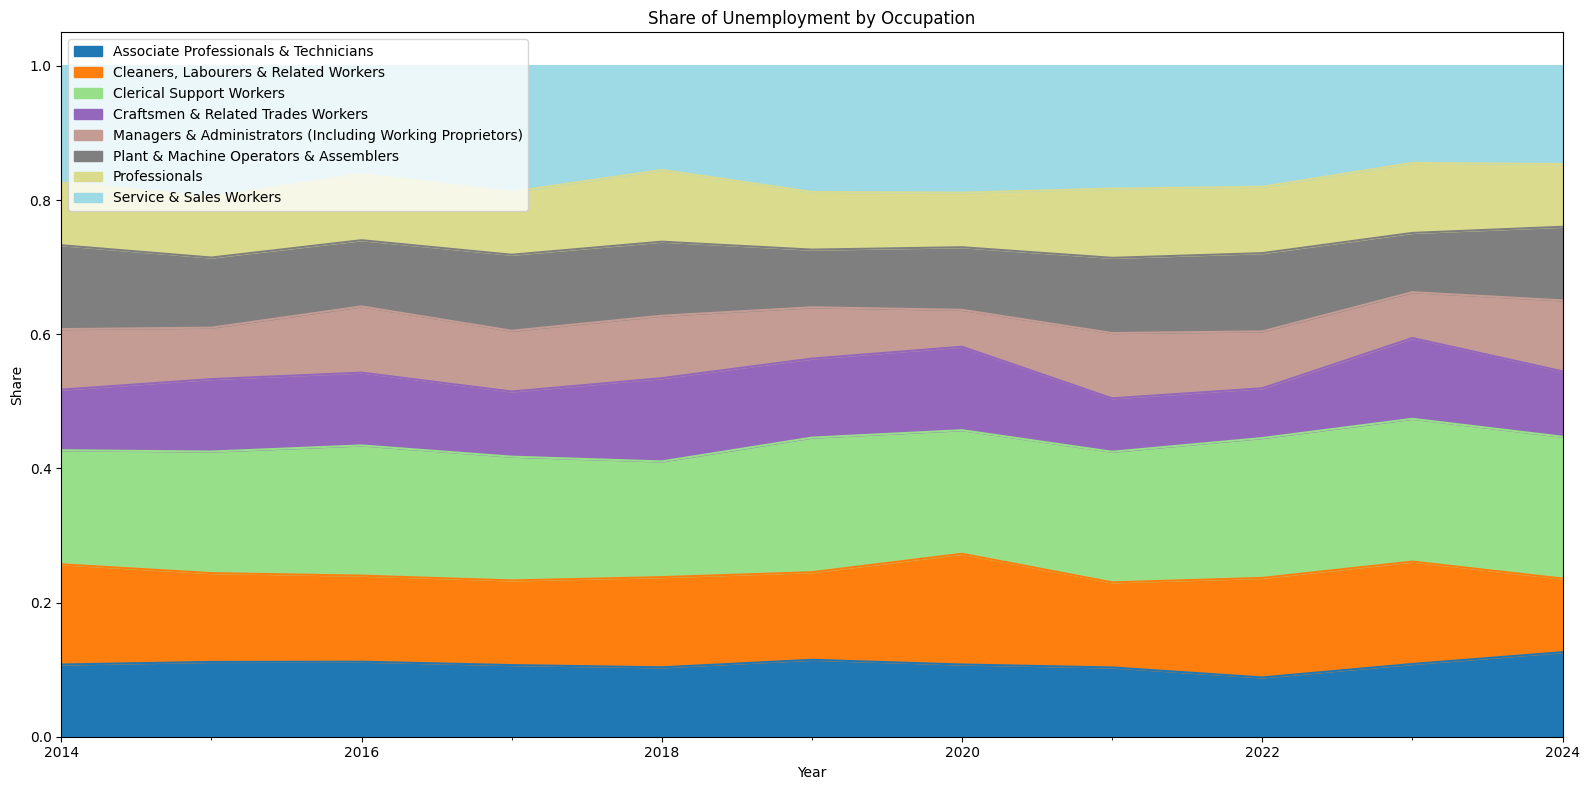

In [ ]:
#Seaborn Example:
# Prepare df so columns are occupations, index=year, values=unemployment or proportion
pivot_sum_df = df.pivot_table(index='year', columns='occupation', values='unemployed_rate', aggfunc='sum')

pivot_sum_df = pivot_sum_df.divide(pivot_sum_df.sum(axis=1), axis=0)  # for proportions/%
pivot_sum_df.plot.area(figsize=(16,8), colormap='tab20')
plt.title('Share of Unemployment by Occupation')
plt.ylabel('Share')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


#Plotly Example:
fig = px.area(pivot_sum_df.reset_index(), x='year', y=pivot_sum_df.columns,
              title='Share of Unemployment by Occupation (2014-2024)',
              groupnorm='fraction')
fig.show()

> Lower-skilled groups, particularly Clerical Support Workers and Service & Sales Workers, contribute disproportionately to overall unemployment, with a marked surge in 2020. Higher-skilled occupations such as Professionals and Managers consistently account for a smaller share, reflecting greater resilience.

## Human capital lens — demographic mediators of unemployment risk

To understand how human capital factors shape unemployment within each occupation family, we explore education tiers, gender splits, and age groups using the long-format tables already materialised in `df_long_dict`. The following plots focus on the occupations with the largest unemployed counts so that the contrasts are easy to interpret.

In [19]:
# Helper utilities to locate relevant columns and compute subgroup shares
from typing import Iterable
import numpy as np

def _find_column(df: pd.DataFrame, keywords: Iterable[str]):
    """Return the first column whose lowercase name contains any of the keywords."""
    lowered = {col.lower(): col for col in df.columns}
    for key in keywords:
        for col_lower, original in lowered.items():
            if key in col_lower:
                return original
    return None

def prepare_demographic_share(df: pd.DataFrame, dimension_keywords: Iterable[str], collapse_gender: bool = False):
    """
    Normalise a long-format table so that each row expresses the share of unemployed_count
    for a demographic dimension (education tier, gender, or age group).
    """
    df_work = df.copy()
    year_col = _find_column(df_work, ["year"])
    occ_col = _find_column(df_work, ["occupation"])
    dim_col = _find_column(df_work, dimension_keywords)
    count_col = _find_column(df_work, ["unemployed_count", "unemployment_count", "unemp_count"])
    if not all([year_col, occ_col, dim_col, count_col]):
        raise KeyError(f"Missing required columns: year={year_col}, occupation={occ_col}, dimension={dim_col}, unemployed_count={count_col}")

    if collapse_gender:
        gender_col = _find_column(df_work, ["gender", "sex"])
        if gender_col:
            df_work = (
                df_work
                .groupby([year_col, occ_col, dim_col], as_index=False)[count_col]
                .sum()
            )

    if pd.api.types.is_datetime64_any_dtype(df_work[year_col]):
        df_work[year_col] = df_work[year_col].dt.year
    else:
        df_work[year_col] = pd.to_numeric(df_work[year_col], errors="coerce")
    df_work[count_col] = pd.to_numeric(df_work[count_col], errors="coerce")
    df_work = df_work.dropna(subset=[year_col, dim_col, count_col])

    totals = df_work.groupby([year_col, occ_col])[count_col].transform("sum")
    df_work = df_work[totals > 0].copy()
    df_work["share_pct"] = (df_work[count_col] / totals.loc[df_work.index]) * 100.0
    df_work = df_work.dropna(subset=["share_pct"])
    return df_work, year_col, occ_col, dim_col, count_col

### Education tiers within occupation families
We aggregate the unemployed counts by occupation, qualification level, and year to understand how education pathways mediate risk. The chart spotlights the six occupations with the highest unemployed counts and shows the share contributed by each qualification tier.

In [31]:
education_raw = df_long_dict.get('unemployed_by_qualification_sex_long')
if education_raw is None:
    raise KeyError("Table 'unemployed_by_qualification_sex_long' is not available in df_long_dict")

# Since education data doesn't have occupations, we'll visualize the overall distribution by education level
education_grouped = education_raw.groupby(['year', 'education'])['unemployed_count'].sum().reset_index()

# Convert year to int for consistency (if it's datetime)
if pd.api.types.is_datetime64_any_dtype(education_grouped['year']):
    education_grouped['year'] = education_grouped['year'].dt.year

# Calculate percentages
education_grouped['total_by_year'] = education_grouped.groupby('year')['unemployed_count'].transform('sum')
education_grouped['share_pct'] = (education_grouped['unemployed_count'] / education_grouped['total_by_year']) * 100

# Define education level order (from lowest to highest)
edu_order = [
    "Below Secondary", 
    "Secondary", 
    "Post-Secondary (Non-Tertiary)", 
    "Diploma & Professional Qualification", 
    "Degree"
]

# Create a custom color scale
colors = px.colors.qualitative.Bold

# Create the visualization
fig_education = px.area(
    education_grouped,
    x='year',
    y='share_pct',
    color='education',
    color_discrete_map={edu: colors[i % len(colors)] for i, edu in enumerate(edu_order)},
    category_orders={"education": edu_order},
    labels={'year': "Year", "share_pct": "Share of unemployed (%)", 'education': "Education tier"},
    title="Education tiers driving unemployment share over time",
    height=650,
    hover_data={'unemployed_count': ':.1f', 'share_pct': ':.1f'}
)
fig_education.update_yaxes(range=[0, 100])
fig_education.update_layout(
    legend_title_text="Education tier", 
    hovermode="x unified",
    legend=dict(traceorder="reversed")
)
fig_education.show()

The share view highlights which education bands contribute most to unemployment per occupation — for instance, whether clerical roles are dominated by secondary-educated jobseekers or if professional tiers remain resilient. Spikes in particular years (e.g. 2020) call attention to qualification segments that need reskilling focus.

### Gender exposure within occupation families
We now compare male versus female unemployment contributions, again focusing on the highest-volume occupations. This helps identify sectors where one gender is disproportionately affected.

In [41]:
gender_raw = df_long_dict.get('unemployed_by_previous_occupation_sex_long')
if gender_raw is None:
    raise KeyError("Table 'unemployed_by_previous_occupation_sex_long' is not available in df_long_dict")
gender_df, gen_year, gen_occ, gen_dim, gen_count = prepare_demographic_share(
    gender_raw, ["gender", "sex"]
)
top_gender_occupations = (
    gender_df.groupby(gen_occ)[gen_count]
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
)
gender_focus = gender_df[gender_df[gen_occ].isin(top_gender_occupations)].copy()
fig_gender = px.area(
    gender_focus,
    x=gen_year,
    y="share_pct",
    color=gen_dim,
    facet_col=gen_occ,
    facet_col_wrap=3,
    category_orders={gen_dim: sorted(gender_focus[gen_dim].unique())},
    color_discrete_map={"Female": "pink", "Male": "blue"},
    labels={gen_year: "Year", "share_pct": "Share of unemployed (%)", gen_dim: "Gender"},
    title="Gender share of unemployment within top occupations",
    height=650
 )
fig_gender.update_yaxes(matches=None, range=[0, 100])
fig_gender.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig_gender.update_layout(legend_title_text="Gender", hovermode="x unified")
fig_gender.show()

Gender splits make it clear where female- or male-dominated unemployment spikes occur — valuable for tailoring targeted interventions such as childcare support or reemployment schemes for affected cohorts. Persistent gaps signal structural issues within specific occupations.

### Age group differentials within occupation families
Finally, we collapse gender and examine age brackets to see which stages of the workforce drive unemployment risk inside each occupation.

In [46]:
# Retrieve age-based unemployment data
age_raw = df_long_dict.get('unemployed_by_age_sex_long')
if age_raw is None:
    raise KeyError("Table 'unemployed_by_age_sex_long' is not available in df_long_dict")

# Identify relevant columns
age_count_col = _find_column(age_raw, ["unemployed_count", "unemployment_count", "unemp_count"])
if age_count_col is None:
    raise KeyError("Unable to locate unemployed count column for age analysis")
    
age_dim_col = _find_column(age_raw, ["age_group", "ageband", "age bracket", "age"])
if age_dim_col is None:
    raise KeyError("Unable to locate age group column for age analysis")

year_col = _find_column(age_raw, ["year"])
gender_col = _find_column(age_raw, ["gender", "sex"])

# Create age data collapsed by gender if needed
if gender_col:
    age_collapsed = (
        age_raw.groupby([year_col, age_dim_col], as_index=False)[age_count_col]
        .sum()
    )
else:
    age_collapsed = age_raw.copy()

# If occupation isn't present, create a placeholder
if 'occupation' not in age_collapsed.columns:
    age_collapsed['occupation'] = 'Overall'
    occ_col = 'occupation'
else:
    occ_col = _find_column(age_collapsed, ["occupation"])

# Prepare demographic share data
age_df, age_year, age_occ, age_dim, age_count = prepare_demographic_share(
    age_collapsed, ["age_group", "ageband", "age bracket", "age"], collapse_gender=False
)

# Find top occupations by unemployment count
if len(age_df[age_occ].unique()) == 1:
    top_age_occupations = age_df[age_occ].unique()
else:
    top_age_occupations = (
        age_df.groupby(age_occ)[age_count]
        .sum()
        .sort_values(ascending=False)
        .head(6)
        .index
    )

# Filter data to focus on top occupations
age_focus = age_df[age_df[age_occ].isin(top_age_occupations)].copy()

# Create a custom color map for better differentiation between age groups
age_groups = sorted(age_focus[age_dim].unique())
colors = px.colors.qualitative.Bold  # Using a qualitative color scheme
age_color_map = {age: colors[i % len(colors)] for i, age in enumerate(age_groups)}

# Create visualization
if len(age_df[age_occ].unique()) == 1:
    fig_age = px.area(
        age_focus,
        x=age_year,
        y="share_pct",
        color=age_dim,
        category_orders={age_dim: age_groups},
        color_discrete_map=age_color_map,
        labels={age_year: "Year", "share_pct": "Share of unemployed (%)", age_dim: "Age group"},
        title="Age group share of overall unemployment",
        height=650
    )
else:
    fig_age = px.area(
        age_focus,
        x=age_year,
        y="share_pct",
        color=age_dim,
        facet_col=age_occ,
        facet_col_wrap=3,
        category_orders={age_dim: age_groups},
        color_discrete_map=age_color_map,
        labels={age_year: "Year", "share_pct": "Share of unemployed (%)", age_dim: "Age group"},
        title="Age group share of unemployment within top occupations",
        height=650
    )

# Finalize visualization settings
fig_age.update_yaxes(matches=None, range=[0, 100])
fig_age.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig_age.update_layout(legend_title_text="Age group", hovermode="x unified")
fig_age.show()

Age profiles show whether youth entrants or mature workers bear the brunt of unemployment shocks inside each occupation. Combining this with the education and gender lenses provides a holistic view of which human capital segments require targeted support.